In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

from tensorflow.keras.layers import Layer, Lambda, Conv2D, Dropout,Dense,Activation,Input,GlobalAveragePooling1D, Concatenate, GlobalAveragePooling2D, LayerNormalization, MaxPool2D
from tensorflow.keras.layers import Reshape,Flatten,BatchNormalization,MaxPooling1D,AveragePooling2D,Reshape,Attention, ReLU, Activation, SpatialDropout2D, DepthwiseConv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from tqdm.auto import tqdm
import os
from Config import Config
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Mean, CategoricalAccuracy
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from datetime import datetime
import random
import matplotlib.pyplot as plt
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError

import tensorflow as tf
tf.config.run_functions_eagerly(True)

import warnings
warnings.filterwarnings('always')

from utils import *
from my_models import *

In [2]:
seed_everything(42)

In [3]:
DATA_ROOT = 'TIMNET-dataset'
DATA_PATH = 'IEMOCAP'
CLASS_LABELS = Config.IEMOCAP_LABELS
k = 10

model_name = 'exp1_remove Spatial-attn'
feature_name = 'mfcc'

learning_rate=0.001
beta_1=0.975
beta_2=0.932
epsilon=1e-8

EPOCHS = 300
BATCH = 32

In [4]:
class Model(tf.keras.Model):

  def __init__(self, num_classes):
    super().__init__()
    
    self.conv1 = Sequential([
      Conv2D(filters=64, kernel_size=3),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2)
    ])
    
    self.conv2 = Sequential([
      Conv2D(filters=64, kernel_size=3, dilation_rate=2),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2),
    ])
    
    self.cbam = CBAM(64) # sharing
    
    self.primarycap = PrimaryCap()
    
    self.attention = Attention(use_scale=True)
    self.LN = LayerNormalization()
    
    self.lamb = Lambda(lambda x: tf.multiply(x[0], x[1]))
    
    self.capsule = Capsule(6,64,3,True)
    self.gap = GlobalAveragePooling1D()
    self.dropout = Dropout(0.2)
    self.classifier = Dense(num_classes, activation='softmax')
    
    
  def call(self, inputs):
    x = tf.reverse(inputs, axis=[2])
    
    cap = self.conv1(x)
    cap = cap + self.cbam(cap)
    cap = self.conv2(cap)
    cap = cap + self.cbam(cap)
    
    primarycaps = self.primarycap(cap)
    
    cap = primarycaps
    
    sa = self.attention([primarycaps, primarycaps, primarycaps])
    sa = self.LN(sa)
    cap = self.lamb([cap, sa])
    
    capsule = self.capsule(cap)
    gap = self.gap(capsule)
    drop = self.dropout(gap)
    
    output_softmax = self.classifier(drop)
    return output_softmax

In [5]:
model = Model(len(CLASS_LABELS))
model.build(input_shape=(None, 196, 39, 1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 97, 18, 64)        1416      
                                                                 
 sequential_1 (Sequential)   (None, 46, 7, 64)         37300     
                                                                 
 cbam (CBAM)                 multiple                  4294      
                                                                 
 primary_cap (PrimaryCap)    multiple                  25600     
                                                                 
 attention (Attention)       multiple                  1         
                                                                 
 layer_normalization (LayerN  multiple                 128       
 ormalization)                                                   
                                                             

In [6]:
def margin_loss(y_true, y_pred):
    """
        Margin Loss
        :param y_true: [None, n_classes]
        :param y_pred: [None, num_capsule]
        :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [7]:
@tf.function
def train_step(model, optimizer, x, labels):
    with tf.GradientTape() as tape:
        # 미분 계산
        predictions = model(x, training=True)
        loss1 = margin_loss(labels, predictions)
        loss2 = MeanSquaredError()(labels, predictions)
        
        loss = loss1*1. + loss2*0.392
        
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))     # 신경망 파라미터 업데이트
    
    acc = tf.keras.metrics.CategoricalAccuracy()
    acc.update_state(labels, predictions)
    accuracy = acc.result().numpy()
    
    return loss, accuracy*100

def test_step(model, x, labels):
    predictions = model(x)
    loss1 = margin_loss(labels, predictions)
    loss2 = MeanSquaredError()(labels, predictions)
    loss = loss1*1. + loss2*0.392
    
    acc = tf.keras.metrics.CategoricalAccuracy()
    acc.update_state(labels, predictions)
    accuracy = acc.result().numpy()
    
    return loss, accuracy*100, predictions

In [8]:
# Read data
with open(f'{DATA_ROOT}/{DATA_PATH}.npy', 'rb') as f:
    x = np.load(f)
    y = np.load(f)

y = to_categorical(y,num_classes=len(CLASS_LABELS))

In [9]:
LEARNING_RATE_DECAY_PARAMETERS = -0.15
LEARNING_RATE_DECAY_STRATPOINT = 50
LEARNING_RATE_DECAY_STEP = 20


def scheduler(epoch, lr):
    if epoch < LEARNING_RATE_DECAY_STRATPOINT:
        return lr
    else:
        if epoch % LEARNING_RATE_DECAY_STEP == 0:
            lr = lr * tf.math.exp(LEARNING_RATE_DECAY_PARAMETERS)
    return lr

In [10]:
# Smooth label operation
def smooth_labels(labels, factor=0.1):
    """
        smooth the labels
        returned the smoothed labels
    """
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
    return labels

In [11]:
from discord_notice import start, end
# start()

A Jupyter Widget

A Jupyter Widget

1/300 lr=0.00100 - loss:0.460, acc:42.061, val_loss:0.450, val_acc:44.464
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.432, acc:47.131, val_loss:0.431, val_acc:46.566
Best loss:0.450, Best accuracy:44.464, Best F1-score:0.432
3/300 lr=0.00100 - loss:0.426, acc:48.217, val_loss:0.431, val_acc:46.740
Best loss:0.431, Best accuracy:46.566, Best F1-score:0.447
4/300 lr=0.00100 - loss:0.419, acc:49.119, val_loss:0.416, val_acc:50.386
Best loss:0.431, Best accuracy:46.740, Best F1-score:0.460
5/300 lr=0.00100 - loss:0.415, acc:50.550, val_loss:0.433, val_acc:45.949
Best loss:0.416, Best accuracy:50.386, Best F1-score:0.500
6/300 lr=0.00100 - loss:0.410, acc:51.583, val_loss:0.404, val_acc:50.733
Best loss:0.416, Best accuracy:50.386, Best F1-score:0.500
7/300 lr=0.00100 - loss:0.402, acc:53.165, val_loss:0.397, val_acc:50.907
Best loss:0.404, Best accuracy:50.733, Best F1-score:0.497
8/300 lr=0.00100 - loss:0.398, acc:53.299, val_loss:0.396, val

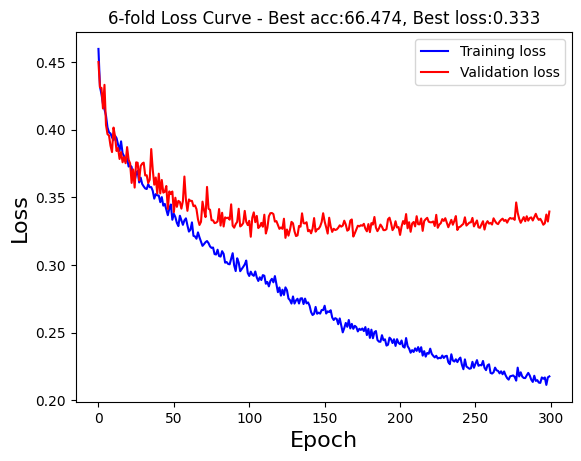

A Jupyter Widget

1/300 lr=0.00100 - loss:0.458, acc:42.419, val_loss:0.427, val_acc:46.393
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.434, acc:46.795, val_loss:0.418, val_acc:49.344
Best loss:0.427, Best accuracy:46.393, Best F1-score:0.477
3/300 lr=0.00100 - loss:0.424, acc:48.711, val_loss:0.423, val_acc:51.601
Best loss:0.418, Best accuracy:49.344, Best F1-score:0.497
4/300 lr=0.00100 - loss:0.415, acc:50.454, val_loss:0.391, val_acc:50.984
Best loss:0.423, Best accuracy:51.601, Best F1-score:0.495
5/300 lr=0.00100 - loss:0.414, acc:50.151, val_loss:0.391, val_acc:53.434
Best loss:0.423, Best accuracy:51.601, Best F1-score:0.495
6/300 lr=0.00100 - loss:0.406, acc:52.143, val_loss:0.383, val_acc:52.546
Best loss:0.391, Best accuracy:53.434, Best F1-score:0.538
7/300 lr=0.00100 - loss:0.403, acc:53.252, val_loss:0.380, val_acc:54.726
Best loss:0.391, Best accuracy:53.434, Best F1-score:0.538
8/300 lr=0.00100 - loss:0.400, acc:53.450, val_loss:0.374, val

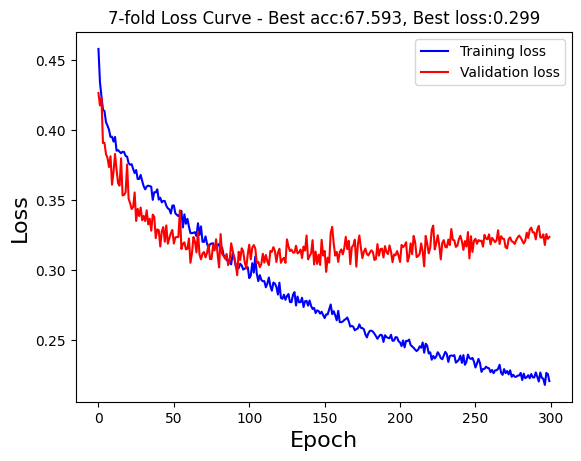

A Jupyter Widget

1/300 lr=0.00100 - loss:0.455, acc:42.432, val_loss:0.440, val_acc:45.525
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.430, acc:47.438, val_loss:0.428, val_acc:46.219
Best loss:0.440, Best accuracy:45.525, Best F1-score:0.446
3/300 lr=0.00100 - loss:0.420, acc:49.379, val_loss:0.418, val_acc:48.052
Best loss:0.428, Best accuracy:46.219, Best F1-score:0.463
4/300 lr=0.00100 - loss:0.414, acc:50.625, val_loss:0.407, val_acc:49.691
Best loss:0.418, Best accuracy:48.052, Best F1-score:0.476
5/300 lr=0.00100 - loss:0.412, acc:51.086, val_loss:0.401, val_acc:49.614
Best loss:0.407, Best accuracy:49.691, Best F1-score:0.490
6/300 lr=0.00100 - loss:0.402, acc:53.303, val_loss:0.392, val_acc:53.434
Best loss:0.407, Best accuracy:49.691, Best F1-score:0.490
7/300 lr=0.00100 - loss:0.397, acc:54.318, val_loss:0.387, val_acc:52.739
Best loss:0.392, Best accuracy:53.434, Best F1-score:0.533
8/300 lr=0.00100 - loss:0.396, acc:54.022, val_loss:0.397, val

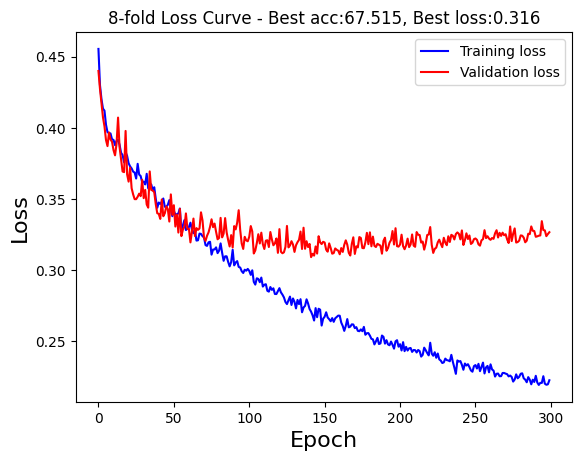

A Jupyter Widget

1/300 lr=0.00100 - loss:0.458, acc:42.270, val_loss:0.421, val_acc:47.801
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.431, acc:47.808, val_loss:0.408, val_acc:47.685
Best loss:0.421, Best accuracy:47.801, Best F1-score:0.472
3/300 lr=0.00100 - loss:0.432, acc:47.356, val_loss:0.405, val_acc:50.656
Best loss:0.421, Best accuracy:47.801, Best F1-score:0.472
4/300 lr=0.00100 - loss:0.418, acc:50.396, val_loss:0.386, val_acc:52.836
Best loss:0.405, Best accuracy:50.656, Best F1-score:0.498
5/300 lr=0.00100 - loss:0.416, acc:50.427, val_loss:0.388, val_acc:55.440
Best loss:0.386, Best accuracy:52.836, Best F1-score:0.524
6/300 lr=0.00100 - loss:0.414, acc:50.445, val_loss:0.381, val_acc:53.183
Best loss:0.388, Best accuracy:55.440, Best F1-score:0.546
7/300 lr=0.00100 - loss:0.408, acc:51.948, val_loss:0.378, val_acc:55.093
Best loss:0.388, Best accuracy:55.440, Best F1-score:0.546
8/300 lr=0.00100 - loss:0.408, acc:52.366, val_loss:0.366, val

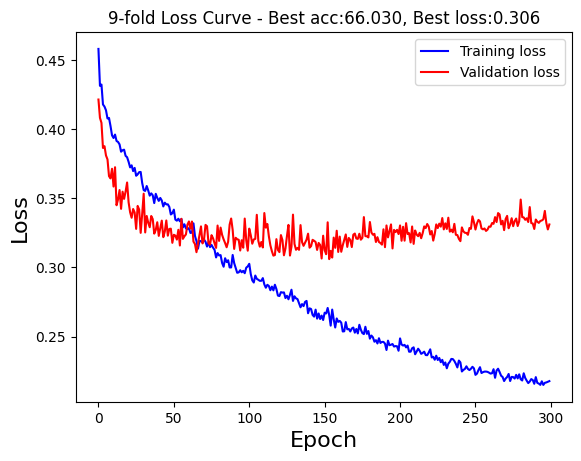

A Jupyter Widget

1/300 lr=0.00100 - loss:0.458, acc:42.065, val_loss:0.426, val_acc:46.142
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.436, acc:45.982, val_loss:0.411, val_acc:49.537
Best loss:0.426, Best accuracy:46.142, Best F1-score:0.441
3/300 lr=0.00100 - loss:0.432, acc:46.227, val_loss:0.406, val_acc:54.398
Best loss:0.411, Best accuracy:49.537, Best F1-score:0.492
4/300 lr=0.00100 - loss:0.425, acc:48.618, val_loss:0.401, val_acc:54.070
Best loss:0.406, Best accuracy:54.398, Best F1-score:0.537
5/300 lr=0.00100 - loss:0.417, acc:48.954, val_loss:0.383, val_acc:58.410
Best loss:0.406, Best accuracy:54.398, Best F1-score:0.537
6/300 lr=0.00100 - loss:0.407, acc:52.083, val_loss:0.376, val_acc:56.655
Best loss:0.383, Best accuracy:58.410, Best F1-score:0.578
7/300 lr=0.00100 - loss:0.403, acc:52.678, val_loss:0.364, val_acc:58.295
Best loss:0.383, Best accuracy:58.410, Best F1-score:0.578
8/300 lr=0.00100 - loss:0.409, acc:51.193, val_loss:0.386, val

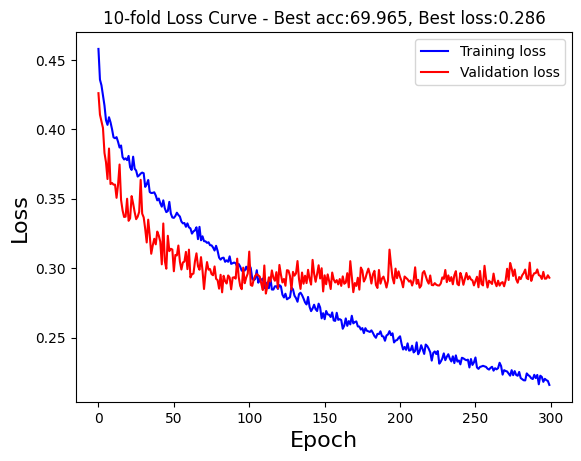

In [12]:
import tensorflow_addons as tfa
from keras.models import load_model

emotions_groundtruth_list = np.array([])
predicted_emotions_list = np.array([])

fold_acc = []

kfold = KFold(n_splits=k, shuffle=True, random_state=98)

for i, (train, test) in tqdm(enumerate(kfold.split(x, y)), desc=f'Training {k}-Fold.....'):
    if i < 5:
        continue
    save_path = f'Models/{DATA_PATH}'
    os.makedirs(save_path, exist_ok=True)
    h5_path = f'{save_path}/{model_name}_{i}-fold_.h5'
    
    x_train, y_train = x[train], y[train]
    y_train = smooth_labels(y[train], 0.1)
    
    x_test, y_test = x[test], y[test]
    
    x_train = tf.expand_dims(x_train, axis=-1)
    x_test = tf.expand_dims(x_test, axis=-1)
    
    shape = x_train.shape[1:]
    
    optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    
    model = Model(len(CLASS_LABELS))
    
    best_test_loss = 0x3f3f3f
    best_test_acc = -1
    best_test_f1 = -1
    
    epoch_losses = []
    valid_losses = []
    
    batch_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(2022).batch(BATCH)
    batch_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH)
    for epoch in tqdm(range(EPOCHS), desc=f'Fold-{i+1}'):

        train_loss, train_acc = [], []
        for features, labels in batch_train:
            loss, acc = train_step(model, optimizer, features, labels)
            train_loss.append(loss)
            train_acc.append(acc)
            
        test_loss, test_acc, f1s = [], [], []
        for features, labels in batch_test:
            loss, acc, pred = test_step(model, features, labels)
            test_loss.append(loss)
            test_acc.append(acc)
            
            f1_metric = tfa.metrics.F1Score(num_classes=len(CLASS_LABELS), average='weighted')
            f1_metric.update_state(labels, pred)
            f1 = f1_metric.result().numpy()
            f1s.append(f1)
            
        
        epoch_loss = sum(train_loss)/len(train_loss)
        epoch_acc = sum(train_acc)/len(train_acc)
        val_loss = sum(test_loss)/len(test_loss)
        val_acc = sum(test_acc)/len(test_acc)
        f1_score = sum(f1s)/len(f1s)
        
        epoch_losses.append(epoch_loss)
        valid_losses.append(val_loss)
        
        cur_lr = K.eval(optimizer.lr)
        print(f'{epoch+1}/{EPOCHS} lr={cur_lr:.5f} - loss:{epoch_loss:.3f}, acc:{epoch_acc:.3f}, val_loss:{val_loss:.3f}, val_acc:{val_acc:.3f}')
        print(f'Best loss:{best_test_loss:.3f}, Best accuracy:{best_test_acc:.3f}, Best F1-score:{best_test_f1:.3f}')
        
        set_lr = scheduler(epoch, K.eval(optimizer.lr))
        K.set_value(optimizer.learning_rate, set_lr)
        
        if best_test_acc < val_acc:
            best_test_acc = val_acc
            best_test_loss = val_loss
            best_test_f1 = f1_score
            model.save_weights(h5_path)
            
            
    model = Model(len(CLASS_LABELS))
    model.build(input_shape=x_train.shape)
    model.load_weights(h5_path)
    
    for features, labels in batch_test:
        best_pred = model(features, training=False)
        emotions_groundtruth_list = np.append(emotions_groundtruth_list, np.argmax(labels, axis=1))
        predicted_emotions_list = np.append(predicted_emotions_list, np.argmax(best_pred, axis=1))
    
    
    print(f'[*] Done - acc:{best_test_acc:.3f}')
    
    plt.title(f'{i+1}-fold Loss Curve - Best acc:{best_test_acc:.3f}, Best loss:{best_test_loss:.3f}')
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.plot(epoch_losses[:],'b')
    plt.plot(valid_losses[:],'r')
    plt.legend(['Training loss','Validation loss'])

    
    save_fig_path = f'Fig/{DATA_PATH}/training/{model_name}'
    os.makedirs(save_fig_path, exist_ok=True)
    plt.savefig(f'{save_fig_path}/{i+1}-fold.PNG')
    
    plt.show()
    
    fold_acc.append(best_test_acc)

In [13]:
end()

In [14]:
print(f'max:{max(fold_acc)}, min:{min(fold_acc)}, average:{sum(fold_acc)/len(fold_acc)}')

max:69.96527777777777, min:66.03009270297156, average:67.51543217235141


In [15]:
import warnings
warnings.filterwarnings('always')

Report = classification_report(emotions_groundtruth_list, predicted_emotions_list)

os.makedirs(f'Results/{DATA_PATH}', exist_ok=True)
report_path = f'Results/{DATA_PATH}/{model_name}_{feature_name}_{k}-fold_nomalize.txt'

with open(report_path, "w") as f:
    f.write(Report)

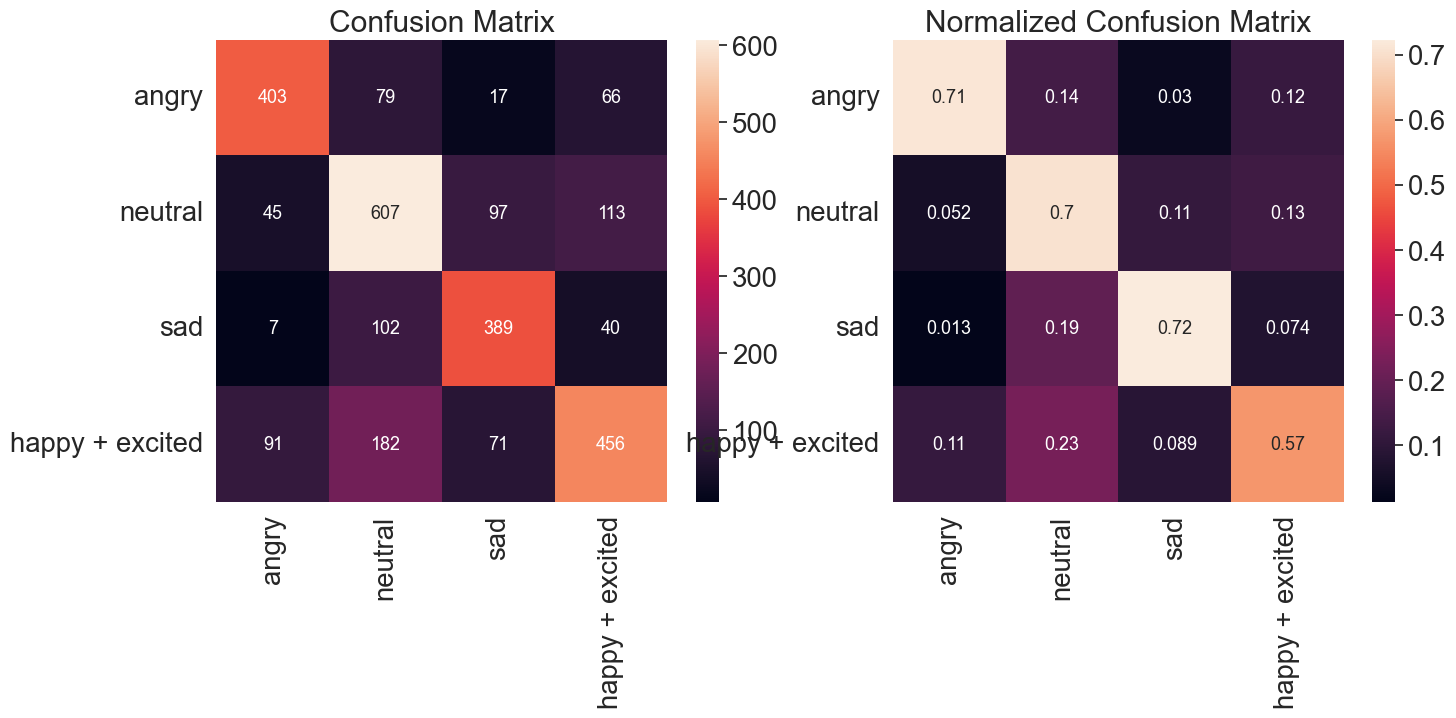

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

emotion_names = CLASS_LABELS


# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth_list, predicted_emotions_list)
conf_matrix_norm = confusion_matrix(emotions_groundtruth_list, predicted_emotions_list,normalize='true')

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 13}, fmt='g') #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font
plt.savefig(f'Results/{DATA_PATH}/{model_name}_{feature_name}_{k}-fold_confmatrix.pdf')
plt.show()

In [17]:
get_metric_calc(conf_matrix)

WAR(Weighted Average Recall)   : 67.76%
UAR(Unweighted Average Recall) : 67.76%
